# How to use prior knowledge in RESIT
## Preparation
### Import and settings

In [1]:
import os
import shutil
import requests

import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.utils import resample, check_array
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import graphviz as gv

from lingam import RESIT
from lingam.bootstrap import BootstrapResult
from lingam.utils import (
    make_dot,
    print_causal_directions,
    print_dagc,
    visualize_nonlinear_causal_effect
)

# versions
import scipy
import sklearn
import matplotlib
import lingam
for lib in [np, pd, scipy, sklearn, matplotlib, lingam]:
    print(lib.__name__, lib.__version__)

numpy 1.26.4
pandas 2.2.3
scipy 1.11.4
sklearn 1.6.1
matplotlib 3.10.3
lingam 1.10.0


In [2]:
np.random.seed(0)

### Download source code
To run this notebook, you need to download and set up the source code for ada_logistic_reg. The source code can be downloaded and imported by executing the code below, but the R and glmnet packages must be installed manually.

In [3]:
def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

# destinaiton of downloaded source code
dirname = "ada_log_reg"
if not os.path.isdir(dirname):
    os.mkdir(dirname)

# download required source code
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/_adaptive_logistic_regression.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/adaptive_logistic_regression.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/__init__.py", dirname=dirname)

from ada_log_reg import predict_adaptive_logistic_regression

# check that dounwloaded source code works properly
try:
    X = np.random.uniform(size=(2, 100))
    y = expit(2 * X[0] - X[1]) >= np.random.uniform(size=100)
    X = np.vstack([X, y]).T
    predict_adaptive_logistic_regression(X, [0, 1], 2)
except:
    raise RuntimeError("Check that the R and glmnet packages are installed and that the path to the Rscript is set correctly.")

# define an interface like scikit-learn
class AdaptiveLogisticRegression:

    def fit(self, X, y):
        X = check_array(X)
        y = check_array(y, ensure_2d=False, dtype=int)
        
        X_ = np.concatenate([X, y.reshape(-1, 1)], axis=1)
        
        predictors = np.arange(len(X.T))
        target = X_.shape[1] - 1
        
        coef = predict_adaptive_logistic_regression(X_, predictors, target)
        
        self.coef_ = coef

## Test data
### Generate test data
We create test data consisting of 8 variables.
In this test data, we set up groups of exogenous, endogenous, and sink variables, and the exogenous and sink variables contain discrete variables. The values of that discrete variables are 0 or 1.

In [4]:
# settings
n_variables = 8
n_sample = 1000
discrete_indices = [0, 7]

# initialize
X = np.zeros((n_variables, n_sample))

# generate test data
def N1(size):
    return np.random.uniform(0, 1, size)

def N2(size):
    return np.random.uniform(1, 2, size)
    
def N3(size):
    return np.random.uniform(-0.1, 0.1, size)

X[0] = (expit(0) >= N1(n_sample)).astype(int)
X[1] = N1(n_sample)
X[2] = N2(n_sample)
X[3] = np.power(X[1], 2) + N3(n_sample)
X[4] = X[1]*X[2] + N3(n_sample)
X[5] = X[0]*X[4] + np.sin(X[3]) + N3(n_sample)
X[6] = -np.cos(X[3] * 4) + 2 + N3(n_sample)
X[7] = (expit(0.4415*X[5] + 0.6925*X[6]) >= N1(n_sample)).astype(int)
names = [f'x{i+1}' for i in range(n_variables)]
X = pd.DataFrame(X.T, columns=names)

# convert types of continuous variables to float, types of discrete variables to int
dtypes = {}
for i, name in enumerate(names):
    dtypes[name] = int if i in discrete_indices else float
X = X.astype(dtypes)
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,0,0.867115,1.682327,0.707949,1.464589,0.701500,3.037128,1
1,0,0.294266,1.805702,0.006176,0.457811,-0.049017,1.036700,1
2,1,0.435353,1.671428,0.189780,0.633763,0.764744,1.286952,0
3,1,0.795457,1.422407,0.717397,1.181053,1.875334,3.005554,1
4,1,0.677508,1.124796,0.482746,0.858713,1.379054,2.385194,1


Histograms of test data are as follows:

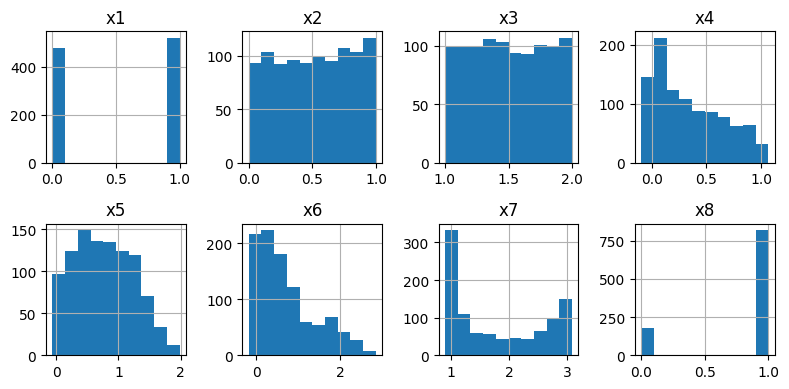

In [5]:
X.hist(layout=(2, 4), figsize=(8, 4))
plt.tight_layout()
plt.show()

Types of test data are as follows:

In [6]:
X.dtypes

x1      int32
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
x8      int32
dtype: object

### Classify test data variables into three subsets
We classify test data variables into three subsets: exogenous variables, endogenous variables, and the sink variable.

In [7]:
exog_var_names = ["x1", "x2", "x3"]
endog_var_names = ["x4", "x5", "x6", "x7"]
sink_var_name = "x8"

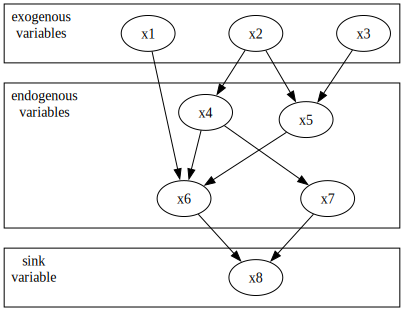

In [8]:
g = gv.Digraph(engine="neato", graph_attr={"splines": "true"})
m = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
])
m = pd.DataFrame(m, columns=names, index=names)

clusters = {
    "exogenous": exog_var_names,
    "endogenous": endog_var_names,
    "sink": [sink_var_name]
}

node_kws = {
    "x1": {"pos": "0,0!"},
    "x2": {"pos": "1.5,0!"},
    "x3": {"pos": "3.0,0!"},
    "x4": {"pos": "0.8,-1.1!"},
    "x5": {"pos": "2.2,-1.2!"},
    "x6": {"pos": "0.5,-2.3!"},
    "x7": {"pos": "2.5,-2.3!"},
    "x8": {"pos": "1.5,-3.4!"}
}

dummy_kws = {
    "exogenous": [("-2,0.4!", "ex_lu"), ("3.5,-0.4!", "ex_rl")],
    "endogenous": [("-2,-0.7!", "en_lu"), ("3.5,-2.7!", "en_rl")],
    "sink": [("-2,-3.0!", "si_lu"), ("3.5,-3.8!", "si_rl")]
}

# add nodes
for cluster, vars_ in clusters.items():
    # make subgraph
    with g.subgraph(name=f"cluster_{cluster}") as sub:
        for var in vars_:
            sub.node(var, var, **node_kws.get(var, {}))
        sub.attr(label=f"{cluster}\nvariable{'s' if cluster != 'sink' else ''}", labeljust="l")
        # dummies
        for pos, name in dummy_kws[cluster]:
            sub.node(name, "", pos=pos, style="invis", fixedsize="true", width="0", height="0")

# add edges
for to_name, coefs in m.iterrows():
    for from_name, coef in coefs.items():
        if not np.isclose(coef, 0):
            g.edge(from_name, to_name)

display(g)

## Causal Discovery
Causal discovery is performed on variables excluding the sink variable.
### Make Prior Knowledge Matrix
Assume that there is no causal relationship between exogenous variables, and set the causal order as follows:

Exogenous variables (x1, x2, x3) → Endogenous variables (x4, x5) → Endogenous variables (x6, x7).

The elements of prior knowledge matrix are defined as follows:
* `0` : `x_i` does not have a directed path to `x_j`
* `1` : `x_i` has a directed path to `x_j`
* `-1` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.

In [9]:
from lingam.utils import make_prior_knowledge
prior_knowledge = make_prior_knowledge(
    n_variables=7,
    exogenous_variables=[0, 1, 2],
    paths=[(a, b) for a in [0, 1, 2] for b in [3, 4]] + [(a, b) for a in [3, 4] for b in [5, 6]]
)
print(prior_knowledge)

[[-1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0]
 [ 1  1  1 -1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1 -1]
 [-1 -1 -1  1  1 -1 -1]
 [-1 -1 -1  1  1 -1 -1]]


To run causal discovery, we create a RESIT object and call the fit method.

In [10]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_depth=4, random_state=0)

exog_and_endog_names = exog_var_names + endog_var_names
model = lingam.RESIT(regressor=regressor, prior_knowledge=prior_knowledge)
model.fit(X[exog_and_endog_names])

B_endog_and_exog = pd.DataFrame(model.adjacency_matrix_, index=exog_and_endog_names, columns=exog_and_endog_names)
B_endog_and_exog

,x1,x2,x3,x4,x5,x6,x7
x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
x5,1.0,1.0,1.0,0.0,0.0,0.0,0.0
x6,1.0,1.0,1.0,1.0,1.0,0.0,0.0
x7,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Next, we estimate a model for the sink variable. Since the sink variable is a discrete variable, a logistic regression model is used.

In [11]:
sink_model = LogisticRegression(penalty=None)
sink_model.fit(X[exog_and_endog_names], X[sink_var_name])

W_sink = pd.DataFrame(sink_model.coef_, index=[sink_var_name], columns=exog_and_endog_names)
W_sink

,x1,x2,x3,x4,x5,x6,x7
x8,-0.092423,-0.417306,0.162495,0.051343,-0.249873,0.588049,0.813112


The adjacency matrix and the coefficients of the model of the sink variable are combined into one adjacency matrix to obtain the results of the analysis.

In [12]:
adj = pd.DataFrame(0.0, index=X.columns, columns=X.columns)
adj.loc[B_endog_and_exog.index, B_endog_and_exog.columns] = B_endog_and_exog
adj.loc[W_sink.index, W_sink.columns] = W_sink
adj

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x5,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
x6,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0
x7,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
x8,-0.092423,-0.417306,0.162495,0.051343,-0.249873,0.588049,0.813112,0.0


### Visualize a result
The causal graph is as follows:

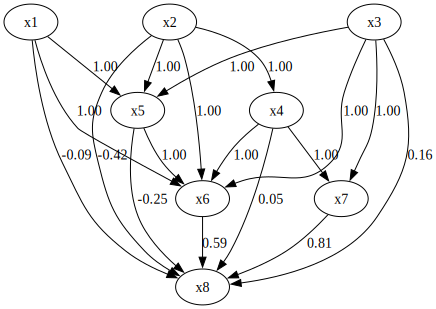

In [13]:
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

### Prune the model for the sink variable
Using AdaptiveLogisticRegression instead of LogsticRegression as the model for the sink variable allows for edge pruning.

In [14]:
sink_model2 = AdaptiveLogisticRegression()
sink_model2.fit(X[exog_and_endog_names], X[sink_var_name])

W_sink2 = pd.DataFrame(sink_model2.coef_, index=[sink_var_name], columns=exog_and_endog_names)

As before, the adjacency matrix and the coefficients of the model of the sink variable are combined into one adjacency matrix to obtain the results of the analysis.

In [15]:
adj = pd.DataFrame(0.0, index=X.columns, columns=X.columns)
adj.loc[B_endog_and_exog.index, B_endog_and_exog.columns] = B_endog_and_exog
adj.loc[W_sink2.index, W_sink2.columns] = W_sink2
adj

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
x2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
x3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
x4,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
x5,1.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.0
x6,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0
x7,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.0
x8,0.0,0.0,0.0,0.0,0.0,0.404841,0.627685,0.0


The causal graph is as follows:

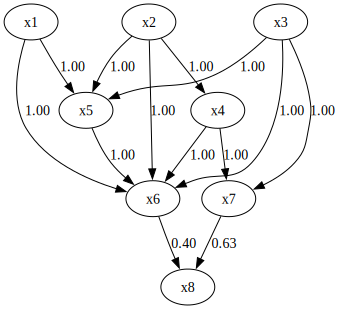

In [16]:
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

### Nonlinear model for the sink variable
We can also use nonlinear logistic regression instead of linear logistic regression.

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Set polynomial feature (2nd order).
poly_degree = 2
sink_model3 = make_pipeline(
    PolynomialFeatures(degree=poly_degree, include_bias=False),
    LogisticRegression()
)
sink_model3.fit(X[exog_and_endog_names], X[sink_var_name])

# Get the names of the polynomial features
poly_features = sink_model3.named_steps['polynomialfeatures']
log_reg = sink_model3.named_steps['logisticregression']
feature_names = poly_features.get_feature_names_out(input_features=exog_and_endog_names)

# Retrieve the regression coefficients and intercept
coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_[0]

# Display the regression equation
print("Estimated logistic regression equation:")
equation = f"{intercept:.3f} + " + " + ".join(
    f"{coef:.3f}*{name}" for coef, name in zip(coefficients, feature_names)
)
print(equation)

Estimated logistic regression equation:
0.127 + -0.012*x1 + -0.010*x2 + 0.160*x3 + 0.189*x4 + 0.664*x5 + 0.286*x6 + 0.537*x7 + -0.012*x1^2 + -0.213*x1 x2 + -0.005*x1 x3 + 0.119*x1 x4 + 0.239*x1 x5 + 0.135*x1 x6 + -0.065*x1 x7 + 0.107*x2^2 + -0.601*x2 x3 + 0.047*x2 x4 + 0.048*x2 x5 + -0.196*x2 x6 + -0.044*x2 x7 + 0.157*x3^2 + -0.311*x3 x4 + -0.257*x3 x5 + -0.120*x3 x6 + -0.207*x3 x7 + 0.031*x4^2 + -0.109*x4 x5 + -0.091*x4 x6 + 0.076*x4 x7 + -0.278*x5^2 + 0.224*x5 x6 + 0.301*x5 x7 + -0.114*x6^2 + 0.191*x6 x7 + 0.051*x7^2


The causal graph is as follows:

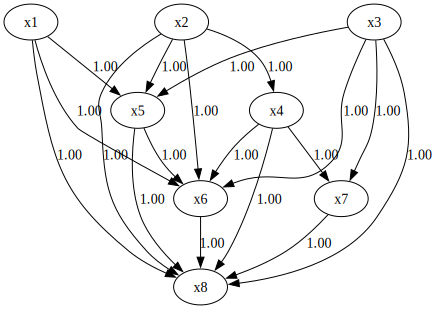

In [18]:
adj = pd.DataFrame(0.0, index=X.columns, columns=X.columns)
adj.loc[B_endog_and_exog.index, B_endog_and_exog.columns] = B_endog_and_exog
adj.loc[sink_var_name, B_endog_and_exog.columns] = 1.0
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

## Analysis with bootstrapping
We perform the same analysis as before with bootstrapping. First, combine the previous analysis into a single function, the run_analysis function, as follows

In [19]:
def run_analysis(X, exog_var_names, endog_var_names, sink_var_name, prior_knowledge, regressor=None, sink_model=None):
    """
    X : pandas.DataFrame
        That data type must be float or int. Variables of type int are interpreted as discrete.
    exog_var_names : list of str
        List of names of exogenous variables.
    endog_var_names : list of str
        List of names of endogenous variables.
    sink_var_name : str
        Name of the sink variable.
    prior_knowledge : 
    
    regressor : object
        
    sink_model : object
        Instance of a model for the sink variable.
    """
    if regressor == None:
        regressor = RandomForestRegressor(max_depth=4, random_state=0)
    exog_and_endog_names = exog_var_names + endog_var_names

    # causal discovery
    model = lingam.RESIT(regressor=regressor, prior_knowledge=prior_knowledge)
    model.fit(X[exog_and_endog_names])
    B_endog_and_exog = pd.DataFrame(model.adjacency_matrix_, index=exog_and_endog_names, columns=exog_and_endog_names)
    
    # model for the given sink variable
    if sink_model == None:
        sink_model = AdaptiveLogisticRegression()
    sink_model.fit(X[exog_and_endog_names], X[sink_var_name])
    W_sink = pd.DataFrame(sink_model.coef_, index=[sink_var_name], columns=exog_and_endog_names)
    
    # make one adjacency matrix
    adj = pd.DataFrame(0.0, index=X.columns, columns=X.columns)
    adj.loc[B_endog_and_exog.index, B_endog_and_exog.columns] = B_endog_and_exog
    adj.loc[W_sink.index, W_sink.columns] = W_sink

    return adj

### Perform bootstrapping

In [20]:
# number of bootstrapping
n_sampling = 100

# number of features
n_features = X.shape[1]

# container of a result
adjs = np.zeros((n_sampling, n_features, n_features))
total_effects = np.zeros([n_sampling, X.shape[1], X.shape[1]])
index = np.arange(X.shape[0])
resampled_indices = []

# perform bootstrapping
for i in range(n_sampling):
    print("\r", i, end="")
    X_resampled, resampled_index = resample(X, index)
    
    # causal discovery on endogenous variabels and a sink variable
    adj = run_analysis(
        X_resampled,
        exog_var_names,
        endog_var_names,
        sink_var_name,
        prior_knowledge,
        regressor = RandomForestRegressor(max_depth=4, random_state=0),
        sink_model = AdaptiveLogisticRegression()
    )
    adjs[i] = adj
    resampled_indices.append(resampled_index)
print("\r\n")

# store results
result = BootstrapResult(adjs, total_effects, resampled_indices=resampled_indices)

 99



### Confirm results of the bootstrapping
For more information on verifying bootstrap results.

### Causal Directions

In [21]:
# variable names of an estimated adjacency matrix
var_names = exog_and_endog_names + [sink_var_name]

cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling, labels=var_names)

x4 <--- x2 (b>0) (100.0%)
x5 <--- x1 (b>0) (100.0%)
x5 <--- x2 (b>0) (100.0%)
x5 <--- x3 (b>0) (100.0%)
x6 <--- x1 (b>0) (100.0%)
x6 <--- x2 (b>0) (100.0%)
x6 <--- x3 (b>0) (100.0%)
x6 <--- x4 (b>0) (100.0%)


### Directed Acyclic Graphs

In [22]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling, labels=var_names)

DAG[0]: 26.0%
	x4 <--- x2 (b>0)
	x5 <--- x1 (b>0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x2 (b>0)
	x6 <--- x3 (b>0)
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x1 (b>0)
	x7 <--- x2 (b>0)
	x7 <--- x3 (b>0)
	x7 <--- x4 (b>0)
	x7 <--- x5 (b>0)
	x7 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[1]: 16.0%
	x4 <--- x2 (b>0)
	x5 <--- x1 (b>0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x2 (b>0)
	x6 <--- x3 (b>0)
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x1 (b>0)
	x7 <--- x2 (b>0)
	x7 <--- x3 (b>0)
	x7 <--- x4 (b>0)
	x7 <--- x5 (b>0)
	x7 <--- x6 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[2]: 4.0%
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x5 <--- x1 (b>0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x2 (b>0)
	x6 <--- x3 (b>0)
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x1 (b>0)
	x7 <--- x2 (b>0)
	x7 <--- x3 (b>0)
	x7 <--- x4 (b>0)
	x7 <--- x5 (b>0)
	x7 <--- x6 (b>0)
	x8 <--- x4 (b>0)


### Bootstrap probability

In [23]:
prob = result.get_probabilities(min_causal_effect=0.01)
prob

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.27, 1.  , 0.11, 0.  , 0.11, 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  ],
       [0.97, 0.92, 0.92, 1.  , 0.82, 0.86, 0.  , 0.  ],
       [0.04, 0.08, 0.03, 0.24, 0.08, 0.4 , 0.72, 0.  ]])

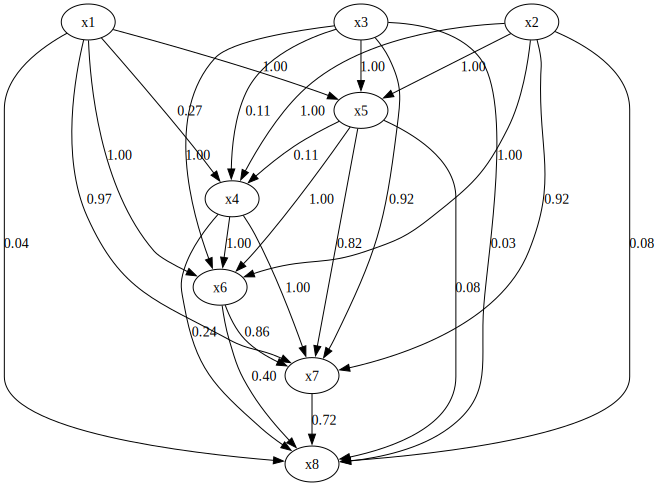

In [24]:
make_dot(prob, labels=var_names, lower_limit=0.0)

## Visualization of nonlinear causal effect
Bootstrap results can be used to visualize the nonlinear causal effect of a cause variable on an outcome variable.

C:\Users\AA006281\AppData\Local\Temp\ipykernel_10596\2603676719.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


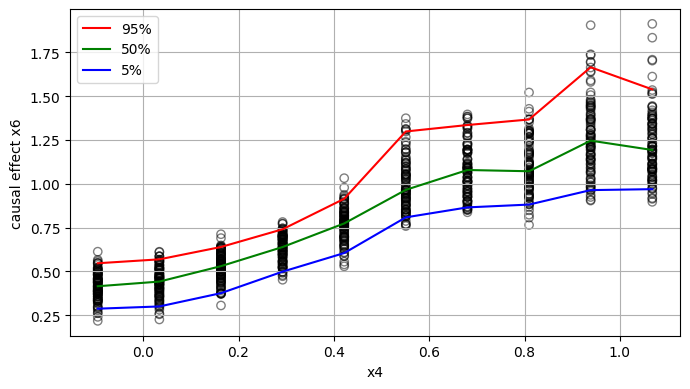

In [25]:
fig = plt.figure(figsize=(7, 4))
fig = visualize_nonlinear_causal_effect(X, result, RandomForestRegressor(), "x4", "x6", fig=fig)

for ax in fig.get_axes():
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.show()